# Time Series

Tools:

- [Pandas](https://pandas.pydata.org/pandas-docs/stable/timeseries.html)
- [Pandas user guide](https://pandas.pydata.org/pandas-docs/stable/timeseries.html)
- [Time Series analysis (TSA) from statsmodels](http://www.statsmodels.org/devel/tsa.html)

References:

- [Basic](https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/)
- [Detailed](https://otexts.com/fpp2/classical-decomposition.html)
- [PennState Time Series course](https://online.stat.psu.edu/stat510/)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Plot parameters
plt.style.use('seaborn-v0_8-whitegrid')
fig_w, fig_h = plt.rcParams.get('figure.figsize')
plt.rcParams['figure.figsize'] = (fig_w, fig_h * .5)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Time series with Pandas

In [2]:
idx = pd.date_range("2018-01-01", periods=5, freq="YS")
ts = pd.Series(range(len(idx)), index=idx)
print(ts)

2018-01-01    0
2019-01-01    1
2020-01-01    2
2021-01-01    3
2022-01-01    4
Freq: YS-JAN, dtype: int64


## Decomposition Methods: Periodic Patterns (Trend/Seasonal) and Autocorrelation

Stationarity

A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time.

- constant mean
- constant variance
- an autocovariance that does not depend on time.

what is making a TS non-stationary. There are 2 major reasons behind non-stationary of a TS:

1. Trend - varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.

2. Seasonality - variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.


### [Time series analysis of Google trends](https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial)

Get Google Trends data of keywords such as 'diet' and 'gym' and see how they vary over time while learning about trends and seasonality in time series data.

In the Facebook Live code along session on the 4th of January, we checked out Google trends data of keywords 'diet', 'gym' and 'finance' to see how they vary over time. We asked ourselves if there could be more searches for these terms in January when we're all trying to turn over a new leaf?

In this tutorial, you'll go through the code that we put together during the session step by step. You're not going to do much mathematics but you are going to do the following:

- Read data
- Recode data
- Exploratory Data Analysis

Read data

In [3]:
try:
    url = "https://github.com/datacamp/datacamp_facebook_live_ny_resolution/raw/master/data/multiTimeline.csv"
    df = pd.read_csv(url, skiprows=2)
except:
    df = pd.read_csv("../datasets/multiTimeline.csv", skiprows=2)

print(df.head())

# Rename columns
df.columns = ['month', 'diet', 'gym', 'finance']

# Describe
print(df.describe())

     Month  diet: (Worldwide)  gym: (Worldwide)  finance: (Worldwide)
0  2004-01                100                31                    48
1  2004-02                 75                26                    49
2  2004-03                 67                24                    47
3  2004-04                 70                22                    48
4  2004-05                 72                22                    43
             diet         gym     finance
count  168.000000  168.000000  168.000000
mean    49.642857   34.690476   47.148810
std      8.033080    8.134316    4.972547
min     34.000000   22.000000   38.000000
25%     44.000000   28.000000   44.000000
50%     48.500000   32.500000   46.000000
75%     53.000000   41.000000   50.000000
max    100.000000   58.000000   73.000000


Recode data

Next, you'll turn the 'month' column into a DateTime data type and make it the index of the DataFrame.

Note that you do this because you saw in the result of the .info() method that the 'Month' column was actually an of data type object. Now, that generic data type encapsulates everything from strings to integers, etc. That's not exactly what you want when you want to be looking at time series data. That's why you'll use .to_datetime() to convert the 'month' column in your DataFrame to a DateTime.

Be careful! Make sure to include the in place argument when you're setting the index of the DataFrame df so that you actually alter the original index and set it to the 'month' column.

In [4]:
df.month = pd.to_datetime(df.month)
df.set_index('month', inplace=True)

df = df[["diet", "gym"]]

print(df.head())

            diet  gym
month                
2004-01-01   100   31
2004-02-01    75   26
2004-03-01    67   24
2004-04-01    70   22
2004-05-01    72   22


Exploratory data analysis

You can use a built-in pandas visualization method .plot() to plot your
data as 3 line plots on a single figure (one for each column, namely, 'diet', 'gym', and 'finance').

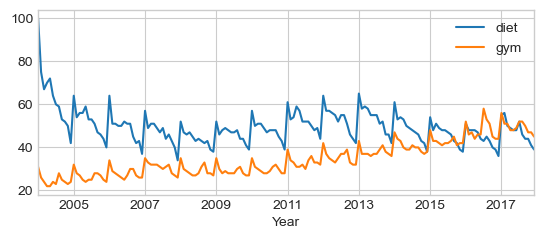

In [5]:
df.plot()
plt.xlabel('Year');

Note that this data is relative. As you can read on Google trends:

Numbers represent search interest relative to the highest point on the chart
for the given region and time.
A value of 100 is the peak popularity for the term.
A value of 50 means that the term is half as popular.
Likewise a score of 0 means the term was less than 1% as popular as the peak.


### Trends : Resampling, Rolling average, (Smoothing, Windowing) 

Identify trends or remove seasonality

1. Subsampling at year frequency

2. Rolling average (Smoothing, Windowing), for each time point, take the average of the points on either side of it. Note that the number of points is specified by a window size.



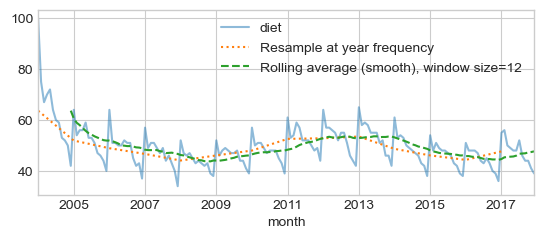

In [6]:
diet = df['diet']

diet_resamp_yr = diet.resample('YE').mean()
diet_roll_yr = diet.rolling(12).mean()

ax = diet.plot(alpha=0.5, style='-') # store axis (ax) for latter plots
diet_resamp_yr.plot(style=':', label='Resample at year frequency', ax=ax)
diet_roll_yr.plot(style='--', label='Rolling average (smooth), window size=12',
                  ax=ax)
_ = ax.legend()

Rolling average (smoothing) with Numpy

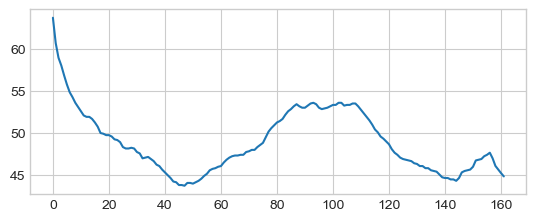

In [7]:
x = np.asarray(df[['diet']])
win = 12
win_half = int(win / 2)

diet_smooth = np.array([x[(idx-win_half):(idx+win_half)].mean()
                        for idx in np.arange(win_half, len(x))])
_ = plt.plot(diet_smooth)

Trends: Plot Diet and Gym using rolling average

Build a new DataFrame which is the concatenation diet and gym smoothed data

Text(0.5, 0, 'Year')

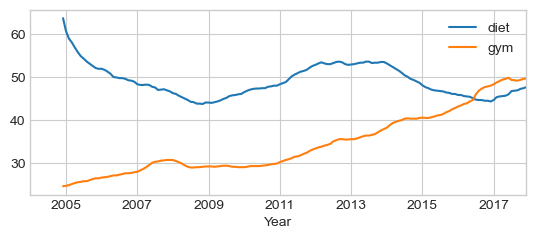

In [8]:
df_trend = pd.concat([df['diet'].rolling(12).mean(), df['gym'].rolling(12).mean()], axis=1)
df_trend.plot()
plt.xlabel('Year')

### Seasonality by detrending (remove average)

Text(0.5, 0, 'Year')

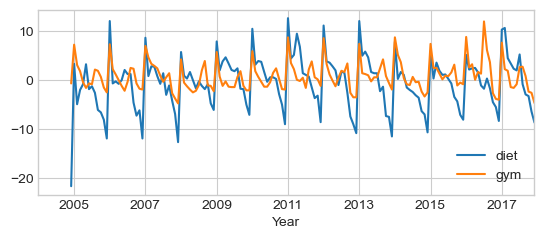

In [9]:
df_dtrend = df[["diet", "gym"]] - df_trend
df_dtrend.plot()
plt.xlabel('Year')

### Seasonality by First-order Differencing

First-order approximation using `diff` method which compute original - shifted data:

Text(0.5, 0, 'Year')

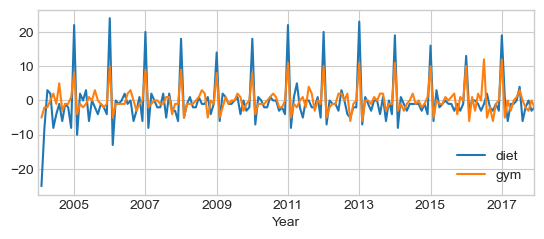

In [10]:
# exclude first term for some implementation details
assert np.all((diet.diff() == diet - diet.shift())[1:])

df.diff().plot()
plt.xlabel('Year')

### Periodicity and Autocorrelation

Correlation matrix

In [11]:
print(df.corr())

          diet       gym
diet  1.000000 -0.100764
gym  -0.100764  1.000000


'diet' and 'gym' are negatively correlated! Remember that you have a seasonal and a trend component. The correlation is actually capturing both of those. Decomposing into separate components provides a better insight of the data:

Trends components that are negatively correlated:

In [12]:
df_trend.corr()

,diet,gym
diet,1.000000,-0.298725
gym,-0.298725,1.000000



Seasonal components (Detrended or First-order Differencing) are positively correlated

In [13]:
print(df_dtrend.corr())
print(df.diff().corr())

          diet       gym
diet  1.000000  0.600208
gym   0.600208  1.000000
          diet       gym
diet  1.000000  0.758707
gym   0.758707  1.000000


`Seasonal_decompose` function of [statsmodels](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html). "The results are obtained by first estimating the trend by applying a using moving averages or a convolution filter to the data. The trend is then removed from the series and the average of this de-trended series for each period is the returned seasonal component."

We use additive (linear) model, i.e., TS = Level + Trend + Seasonality + Noise

- Level: The average value in the series.
- Trend: The increasing or decreasing value in the series.
- Seasonality: The repeating short-term cycle in the series.
- Noise: The random variation in the series.

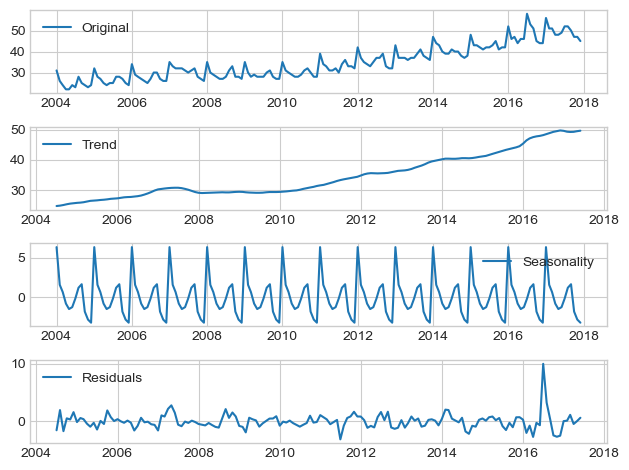

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

x = df.gym.astype(float) # force float
decomposition = seasonal_decompose(x)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


fig, axis = plt.subplots(4, 1, figsize=(fig_w, fig_h))

axis[0].plot(x, label='Original')
axis[0].legend(loc='best')

axis[1].plot(trend, label='Trend')
axis[1].legend(loc='best')

axis[2].plot(seasonal,label='Seasonality')
axis[2].legend(loc='best')

axis[3].plot(residual, label='Residuals')
axis[3].legend(loc='best')

plt.tight_layout()

### Autocorrelation function (ACF)

A time series is periodic if it repeats itself at equally spaced intervals, say, every 12 months.
Autocorrelation Function (ACF): It is a measure of the correlation between the TS with a
lagged version of itself. For instance at lag 5, ACF would compare series at time instant $t$ with series at instant $t-h$.

- The autocorrelation measures the linear relationship between an observation and its previous observations at different lags ($h$).
- Represents the overall correlation structure of the time series.
- Used to identify the order of a moving average (MA) process.

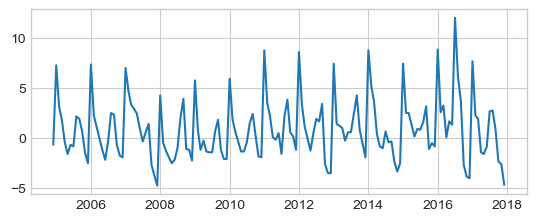

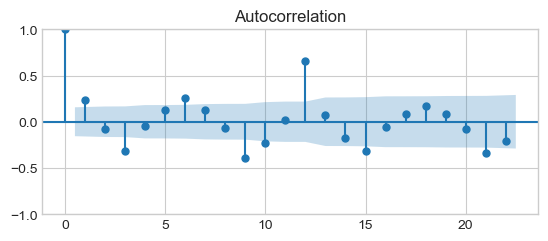

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.stattools import acf, pacf

# We could have considered the first order differences to capture the seasonality
# x = df["gym"].astype(float).diff().dropna()

# Bu we use the detrended signal
x = df_dtrend.gym.dropna()

plt.plot(x)
plt.show()

plot_acf(x)
plt.show()

### Partial autocorrelation function (PACF)

- Partial autocorrelation measures the direct linear relationship between an observation and its previous observations at a specific offset, excluding contributions from intermediate offsets.
- Highlights direct relationships between observations at specific lags.
- Used to identify the order of an autoregressive (AR) process. The partial autocorrelation of an AR(p) process equals zero at lags larger than p, so the appropriate maximum lag p is the one after which the partial autocorrelations are all zero.

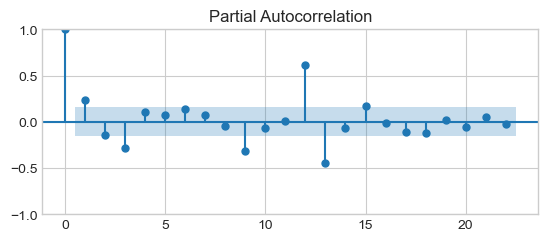

In [16]:
plot_pacf(x)
plt.show()

PACF peaks every 12 months, i.e., the signal is correlated with itself shifted by 12 months. Its, then slowly decrease is due to the trend.

## Time series forecasting using Autoregressive AR(p) models

Sources:

- [Simple modeling with AutoReg](https://www.kaggle.com/code/eugeniyosetrov/simple-modeling-with-autoreg)

The autoregressive orders. In general, we can define an AR(p) model with $p$ autoregressive terms as follows:

$$
x_t = \sum_i^p a_i x_{t-i} + \varepsilon_t
$$

In [17]:
from sklearn.metrics import root_mean_squared_error as rmse
from statsmodels.tsa.api import AutoReg

# We set the frequency for the time series to “MS” (month-start) to avoid warnings when using AutoReg.
x = df_dtrend.gym.dropna().asfreq("MS")
ar1 = AutoReg(x, lags=1).fit()
print(ar1.summary())

                            AutoReg Model Results                             
Dep. Variable:                    gym   No. Observations:                  157
Model:                     AutoReg(1)   Log Likelihood                -387.902
Method:               Conditional MLE   S.D. of innovations              2.908
Date:                Sun, 06 Oct 2024   AIC                            781.803
Time:                        15:14:17   BIC                            790.953
Sample:                    01-01-2005   HQIC                           785.519
                         - 12-01-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6416      0.243      2.641      0.008       0.165       1.118
gym.L1         0.2448      0.078      3.119      0.002       0.091       0.399
                                    Roots           

Partial autocorrelation function (PACF) peaks at $p=12$, try AR(12):

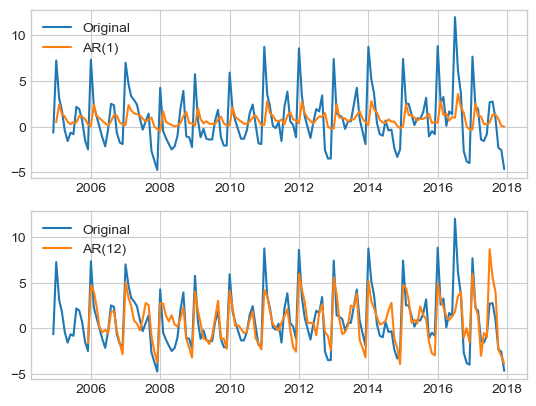

In [18]:
ar12 = AutoReg(x, lags=12).fit()

fig, axis = plt.subplots(2, 1, figsize=(fig_w, fig_h))

axis[0].plot(x, label='Original')
axis[0].plot(ar1.predict(), label='AR(1)')
axis[0].legend(loc='best')

axis[1].plot(x, label='Original')
axis[1].plot(ar12.predict(), label='AR(12)')
_ = axis[1].legend(loc='best')

In [19]:
mae = lambda y_true, y_pred : (y_true - y_pred).dropna().abs().mean()
print("MAE: AR(1) %.3f" % mae(x, ar1.predict()),
      "AR(12) %.3f" % mae(x, ar12.predict()))

MAE: AR(1) 2.093 AR(12) 1.375


Automatic model selection using Akaike information criterion ([AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion)). AIC drops at $p=12$.

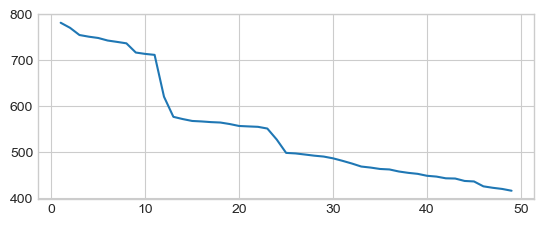

In [20]:
aics = [AutoReg(x, lags=p).fit().aic for p in range(1, 50)]
_ = plt.plot(range(1, len(aics)+1), aics)

## Discrete Fourier Transform (DFT)

![Discrete Fourier Transform](./images/time_series_fft.png)

[Fourier Analysis](https://pythonnumericalmethods.studentorg.berkeley.edu/notebooks/chapter24.00-Fourier-Transforms.html)

- Fourier analysis is a mathematical method used to decompose functions or signals into their constituent frequencies, known as sine and cosine components, that form a orthogonal basis. 
- It transforms a time-domain signal into a frequency-domain representation, making it useful for analyzing periodic or non-periodic signals.
- This technique is widely applied in fields like signal processing, image analysis, and solving differential equations.

[Discrete Fourier Transform (DFT)](https://pythonnumericalmethods.studentorg.berkeley.edu/notebooks/chapter24.02-Discrete-Fourier-Transform.html)

- The Discrete Fourier Transform (DFT) is a specific form of Fourier analysis applied to discrete signals, transforming a finite sequence of equally spaced samples into a frequency-domain representation.
- It breaks down a discrete signal into a sum of sine and cosine waves, each with specific amplitudes and frequencies.
- The DFT is widely used in digital signal processing for tasks like filtering and spectral analysis.

[The Basics of Waves](https://pythonnumericalmethods.studentorg.berkeley.edu/notebooks/chapter24.01-The-Basics-of-waves.html)

A cosine wave can be represented by the following equation:

$$
y(t) = A \cos(2\pi f t + \phi)
$$

- $\phi$ is the phase of the signal.
- $T = 1/f$ is the period of the wave, 
- $f$ is the frequency of the wave
- $A$ is the amplitude of the signal

To generate sample we need to define the sampling rate which is the number of sample per second.

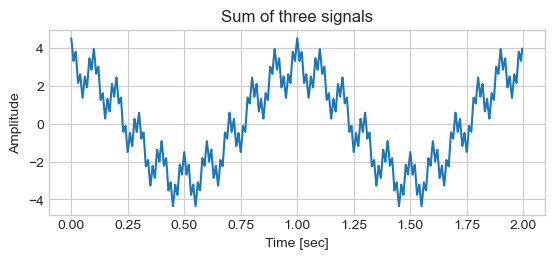

In [21]:
def sine(A=1, f=10, phase=0, duration=1.0, sr=100.0):
    # sampling interval
    ts = 1.0 / sr
    t = np.arange(0, duration, ts)
    return t, A * np.sin(2 * np.pi * f * t + phase)

def cosine(A=1, f=10, phase=0, duration=1.0, sr=100.0):
    # sampling interval
    ts = 1.0 / sr
    t = np.arange(0, duration, ts)
    return t, A * np.cos(2 * np.pi * f * t + phase)

sr = 200

t, sine_1hz = cosine(A=3, f=1, sr=sr, duration=2)
#t, sine_1hz = sine(A=2, f=10, sr=sr, duration=2)
t, sine_10hz = cosine(A=1, f=10, sr=sr, duration=2)
t, sine_50hz = cosine(A=.5, f=50, sr=sr, duration=2)
#t, sine_20hz = sine(A=.5, f=10, sr=sr, duration=2)

y = sine_1hz + sine_10hz + sine_50hz

# Plot the signal
plt.plot(t, y, c=colors[0])
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')
plt.title('Sum of three signals')
plt.show()

[Discrete Cosine Transform DCT](https://en.wikipedia.org/wiki/Discrete_cosine_transform)

- A discrete cosine transform (DCT) expresses a finite sequence of data points in terms of a sum of cosine functions oscillating at different frequencies.
- A DCT is a Fourier-related transform similar to the discrete Fourier transform (DFT), but using only real numbers.
- See also [Discrete Sine Transform DST](https://en.wikipedia.org/wiki/Discrete_sine_transform)

There are several definitions of the DCT, see [DCT with Scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.dct.html) for details. For educational purpose, we use a simplified modified version:
$$
X_k = \sum_{n=0}^{N-1} x_n \cos(\frac{2\pi k n}{N}),
$$
where

- N is the number of samples
- n ie the current sample
- k ie the current frequency, where $k\in [0,N-1]$
- $x_n$ is the sine value at sample $n$
- $X_k$ are the **(frequency terms or DCT)** which include information of  amplitude. It is called the **spectrum of the signal**.

Relation between 

- $f_s$ : Sampling rate or Frequency of Sampling, where 
- $T$ : Duration

$$
f_s = \frac{N}{T}
$$

Generate Signal, as an addition of three cosines at different frequencies: 1 Hz, 10 Hz, and 50 Hz:

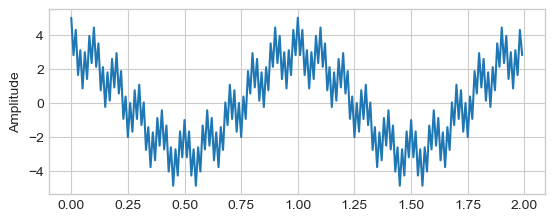

In [22]:
T = 2. # duration
fs = 100 # Sampling rate/frequency: number of samples per second
ts = 1.0 / fs # sampling interval
t = np.arange(0, T, ts) # time axis
N = len(t)

# Generate Signal

x = 0
x += 3.0 * np.cos(2 * np.pi * 1.00 * t)
x += 1.0 * np.cos(2 * np.pi * 10.0 * t)
x += 1.0 * np.cos(2 * np.pi * 50.0 * t)

# Plot

plt.figure()#figsize = (8, 6))
plt.plot(t, x)
plt.ylabel('Amplitude')
plt.show()

Cosines Basis

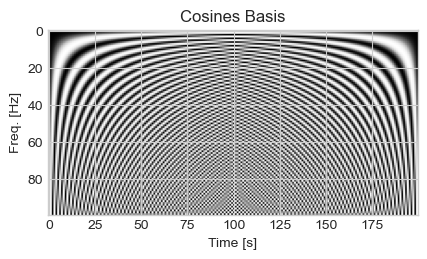

In [23]:
N = len(x)
n = np.arange(N)
k = n.reshape((N, 1))
cosines = np.cos(2 * np.pi * k * n / N)

# Plot

plt.imshow(cosines[:100, :])
plt.xlabel('Time [s]')
plt.ylabel('Freq. [Hz]')
plt.title('Cosines Basis')
plt.show()

Decompose signal on cosine basis (dot product), i.e., DCT without signal normalization

In [24]:
X = np.dot(cosines, x)

# Frequencies = N / T
freqs =  np.arange(N) / T 

# Examine Spectrum, look for frequencies below N / 2

res = pd.DataFrame(dict(freq=freqs, val=X))
res = res[:(N // 2 + 1)]
res = res.iloc[np.where(res.val > 0.01)]
print(res)

     freq    val
2     1.0  300.0
20   10.0  100.0
100  50.0  200.0


[Discrete Fourier Transform (DFT)](https://pythonnumericalmethods.studentorg.berkeley.edu/notebooks/chapter24.02-Discrete-Fourier-Transform.html)

- The Fourier Transform (FT) decompose any signal into a sum of simple sine and cosine waves that we can easily measure the frequency, amplitude and phase.
- FT can be applied to continuous or discrete waves, in this chapter, we will only talk about the **Discrete Fourier Transform (DFT)**."

$$
X_k = \sum_{n=0}^{N-1} x_n e^{-i2\pi k n/N} =  \sum_{n=0}^{N-1} x_n [\cos(2\pi k n/N) - i \sin(2\pi k n/N)],
$$

Where

- $X_k$ are the **(frequency terms or DFT)** which include information of both amplitude and phase. It is called the **spectrum of the signal**.


If the input signal is a real-valued sequence the negative frequency terms are just the complex conjugates of the corresponding positive-frequency terms, and the negative-frequency terms are therefore redundant. The DFT spectrum will be symmetric. Therefore, usually we only plot the DFT corresponding to the positive frequencies and divide by $N/2$  to get the amplitude corresponding to the time domain signal.

The amplitude is the and phase of the signal can be calculated as:

TODO
[FFT](https://pythonnumericalmethods.studentorg.berkeley.edu/notebooks/chapter24.04-FFT-in-Python.html)

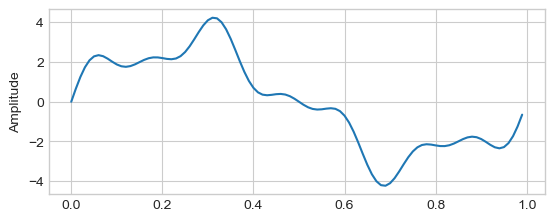

In [25]:
fs = 100 # sampling rate/frequency: number of samples per second
ts = 1.0 / fs # sampling interval
T = 1 # duration
t = np.arange(0, T, ts)

x = 3 * np.sin(2 * np.pi * 1 * t)
x += np.sin(2 * np.pi * 4 * t)
x += 0.5* np.sin(2 * np.pi * 7 * t)

plt.figure()#figsize = (8, 6))
plt.plot(t, x)
plt.ylabel('Amplitude')
plt.show()

   freq    val
1   1.0  150.0
4   4.0   50.0
7   7.0   25.0


/home/ed203246/git/pystatsml/.pixi/envs/default/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ed203246/git/pystatsml/.pixi/envs/default/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


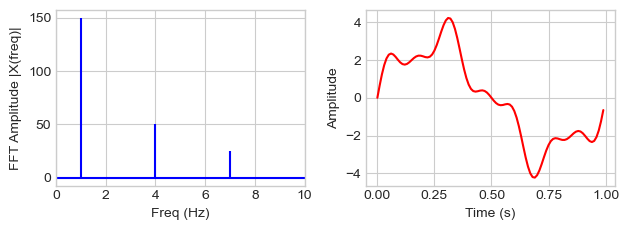

In [26]:
from numpy.fft import fft, ifft

X = fft(x)

# Frequencies

N = len(X) # number of frequencies = number of samples
T = N / fs # duration
freqs =  np.arange(N) / T # Frequencies = N / T

# Examine Spectrum, look for frequencies below N / 2

res = pd.DataFrame(dict(freq=freqs, val=abs(X)))
res = res[:(N // 2 + 1)]
res = res.iloc[np.where(res.val > 0.01)]
print(res)

def plot_fft(X, freqs, t, xlim):

    plt.figure()
    plt.subplot(121)

    plt.stem(freqs, np.abs(X), 'b', \
            markerfmt=" ", basefmt="-b")
    plt.xlabel('Freq (Hz)')
    plt.ylabel('FFT Amplitude |X(freq)|')
    plt.xlim(0, xlim)

    plt.subplot(122)
    plt.plot(t, ifft(X), 'r')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

plot_fft(X, freqs, t, xlim=10)

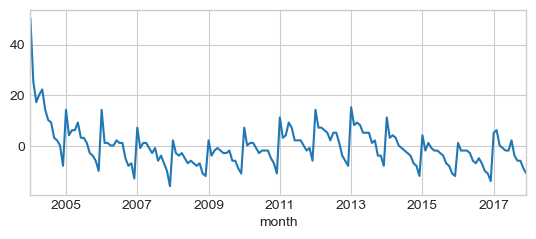

In [27]:
x = df['diet']
x -= x.mean()
x.plot()

fs = 12 # sampling frequency 12 sample / year

In [28]:
X = fft(x)

# Frequencies

N = len(X) # number of frequencies = number of samples
T = N / fs # duration
freqs =  np.arange(N) / T # Frequencies = N / T

# Examine Spectrum, look for frequencies below N / 2

Xn = abs(X)
print(pd.Series(Xn, index=freqs).describe())

res = pd.DataFrame(dict(freq_year=freqs, freq_month=12 / freqs, val=Xn))
res = res[:(N // 2 + 1)]
res = res.iloc[np.where(res.val > 200)]
print(res)

# plot_fft(X, freqs, t, xlim=15)

count    1.680000e+02
mean     6.938104e+01
std      7.745030e+01
min      5.115908e-13
25%      3.132051e+01
50%      4.524089e+01
75%      6.551233e+01
max      4.429661e+02
dtype: float64
    freq_year  freq_month         val
2    0.142857        84.0  442.966103
14   1.000000        12.0  422.372698
28   2.000000         6.0  271.070102
42   3.000000         4.0  215.675682
56   4.000000         3.0  248.131014
70   5.000000         2.4  216.030794
84   6.000000         2.0  240.000000


/tmp/ipykernel_21387/2580075766.py:14: RuntimeWarning: divide by zero encountered in divide
  res = pd.DataFrame(dict(freq_year=freqs, freq_month=12 / freqs, val=Xn))
